Javier Alemán Rodríguez

# Detección de fracturas

### Importación de librerías

In [33]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50

## Lectura, tratamiento y análisis de datos

Mapeamos los dos casos del dataset y estandarizamos el tamaño de las imágenes a 64x64.

In [12]:
MAP_FRACTURED = {
  0: 'fractured', 
  1: 'not fractured'
}

IMG_SIZE = 128

### Carga de las imágenes

In [13]:
def load_set(dirname, map, set_name, verbose=True):
	X = []
	y = []
	print("--------------- Imágenes de {} ---------------".format(set_name))
	for label, case in map.items():
		files = os.listdir(os.path.join(dirname, case))
		images = [file for file in files if file.endswith("jpg") or file.endswith("png")]
		if verbose:
			print("Leyendo {} imágenes encontradas de {}".format(len(images), case))
		for image_name in images:
			image = cv2.imread(os.path.join(dirname, case, image_name))
			if image is not None:
				X.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
				y.append(label)
	return np.array(X), np.array(y)

In [14]:
X_train, y_train = load_set("Bone_Fracture_Binary_Classification/train", MAP_FRACTURED, "train")
X_val, y_val = load_set("Bone_Fracture_Binary_Classification/val", MAP_FRACTURED, "val")
X_test, y_test = load_set("Bone_Fracture_Binary_Classification/test", MAP_FRACTURED, "test")

--------------- Imágenes de train ---------------
Leyendo 4578 imágenes encontradas de fractured
Leyendo 4640 imágenes encontradas de not fractured
--------------- Imágenes de val ---------------
Leyendo 306 imágenes encontradas de fractured
Leyendo 492 imágenes encontradas de not fractured
--------------- Imágenes de test ---------------
Leyendo 238 imágenes encontradas de fractured
Leyendo 268 imágenes encontradas de not fractured


In [15]:
X_train.shape

(9215, 128, 128, 3)

In [16]:
y_train.shape

(9215,)

### Normalización de las imágenes

In [17]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Análisis de los datos a utilizar

In [18]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

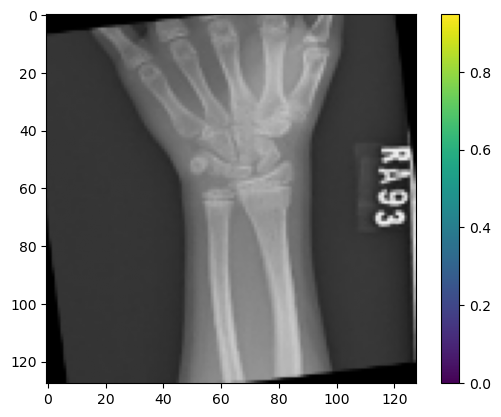

fractured
(128, 128, 3)


In [19]:
visualize_example(X_train[75]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_FRACTURED[y_train[75]]) # Acceso al diccionario
print(X_train[75].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [11]:
filtro_tf =tf.convert_to_tensor(X_train, dtype=tf.float32)
visualize_example(filtro_tf[75])

TypeError: Got an unexpected keyword argument 'shape'

## Preparación para el modelo

In [20]:
num_classes = 2
epochs = 5
img_rows,img_cols = IMG_SIZE,IMG_SIZE
input_shape = (img_rows,img_cols,3) #(64,64,3)

Si imprime [0 1] quiere decir que existen dos clases y por tanto podemos realizar clasificación binaria

In [21]:
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1]
[0 1]
[0 1]


### Gráficas de precisión y pérdida

In [ ]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

### Función para aplicar Fine Tunning

Descongelamos las 4 últimas capas

Recompilamos el modelo y lo reentrenamos

In [56]:
def apply_fine_tunning(model):
	for layer in model.layers[-4:]:
		layer.trainable = True

	model.compile(
		optimizer = 'adam',
		loss = 'binary_crossentropy',
		metrics = ['accuracy']
	)

	early_stopping = EarlyStopping(
		monitor = 'val_accuracy',
		min_delta = 0.01,
		patience = 3,
		mode = 'max',
		restore_best_weights = True
	)

	return model.fit(
		X_train, 
		y_train, 
		epochs = 15, 
		validation_data = (X_val, y_val),
		callbacks = [early_stopping]
	)

## Modelo de red convolucional

Instanciamos las capas, compilamos el modelo con optimizador adam y función de pérdida 'binary_crossentropy', aplicamos Early Stopping para la precisión de los datos de validación y lanzamos el modelo.

Aumentar L2 o disminuir learning rate

Modificar numero de neuronas por capa

In [75]:
model_cnn = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.1)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.1))
])

model_cnn.compile(
  optimizer = keras.optimizers.Adam(learning_rate=0.00001),
	loss = 'binary_crossentropy',
	metrics = ['accuracy']
)

early_stopping = EarlyStopping(
	monitor = 'val_accuracy',
	min_delta = 0.01,
	patience = 3,
	mode = 'max',
	restore_best_weights = True
)

history_cnn = model_cnn.fit(
  X_train, 
  y_train, 
  epochs = 30, 
  validation_data = (X_val, y_val),
  callbacks = [early_stopping]
)

Epoch 1/30
288/288 [==============================] - 49s 167ms/step - loss: 83.0061 - accuracy: 0.5537 - val_loss: 71.4735 - val_accuracy: 0.6917
Epoch 2/30
288/288 [==============================] - 48s 165ms/step - loss: 61.9133 - accuracy: 0.6246 - val_loss: 53.1053 - val_accuracy: 0.7118
Epoch 3/30
288/288 [==============================] - 50s 172ms/step - loss: 45.7975 - accuracy: 0.6577 - val_loss: 39.0674 - val_accuracy: 0.6992
Epoch 4/30
288/288 [==============================] - 51s 177ms/step - loss: 33.5101 - accuracy: 0.6843 - val_loss: 28.4179 - val_accuracy: 0.7055
Epoch 5/30
288/288 [==============================] - 50s 173ms/step - loss: 24.2358 - accuracy: 0.7081 - val_loss: 20.4257 - val_accuracy: 0.7368
Epoch 6/30
288/288 [==============================] - 47s 163ms/step - loss: 17.3285 - accuracy: 0.7261 - val_loss: 14.5294 - val_accuracy: 0.7419
Epoch 7/30
288/288 [==============================] - 48s 166ms/step - loss: 12.2581 - accuracy: 0.7527 - val_loss: 10

KeyboardInterrupt: 

### Aplicamos Fine Tunning

In [57]:
history_cnn_fine = apply_fine_tunning(model_cnn)

Epoch 1/15
288/288 [==============================] - 51s 173ms/step - loss: 0.3029 - accuracy: 0.9552 - val_loss: 0.3913 - val_accuracy: 0.9223
Epoch 2/15
288/288 [==============================] - 48s 166ms/step - loss: 0.2882 - accuracy: 0.9593 - val_loss: 0.3332 - val_accuracy: 0.9248
Epoch 3/15
288/288 [==============================] - 48s 168ms/step - loss: 0.2702 - accuracy: 0.9630 - val_loss: 0.3610 - val_accuracy: 0.9123
Epoch 4/15
288/288 [==============================] - 46s 161ms/step - loss: 0.2482 - accuracy: 0.9660 - val_loss: 0.3202 - val_accuracy: 0.9236


## Modelo ResNet50

In [37]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
	layer.trainable = False

base_model_output = base_model.output
base_model_output = keras.layers.GlobalAveragePooling2D()(base_model_output)  # Usar global average pooling en lugar de flatten
base_model_output = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.02))(base_model_output)
base_model_output = keras.layers.Dropout(0.5)(base_model_output)
predictions = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.02))(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(
  optimizer = 'adam',
	loss = 'binary_crossentropy',
	metrics = ['accuracy']
)

early_stopping = EarlyStopping(
	monitor = 'val_accuracy',
	min_delta = 0.01,
	patience = 3,
	mode = 'max',
	restore_best_weights = True
)

history_resnet = model.fit(
	X_train, 
  y_train, 
  epochs = 15, 
  validation_data = (X_val, y_val),
  callbacks = [early_stopping]
)

Epoch 1/15
288/288 [==============================] - 110s 374ms/step - loss: 0.6874 - accuracy: 0.5598 - val_loss: 0.6493 - val_accuracy: 0.6454
Epoch 2/15
288/288 [==============================] - 105s 366ms/step - loss: 0.6381 - accuracy: 0.6239 - val_loss: 0.6123 - val_accuracy: 0.6767
Epoch 3/15
288/288 [==============================] - 109s 379ms/step - loss: 0.6175 - accuracy: 0.6505 - val_loss: 0.6472 - val_accuracy: 0.6040
Epoch 4/15
278/288 [===========================>..] - ETA: 3s - loss: 0.5981 - accuracy: 0.6745

KeyboardInterrupt: 

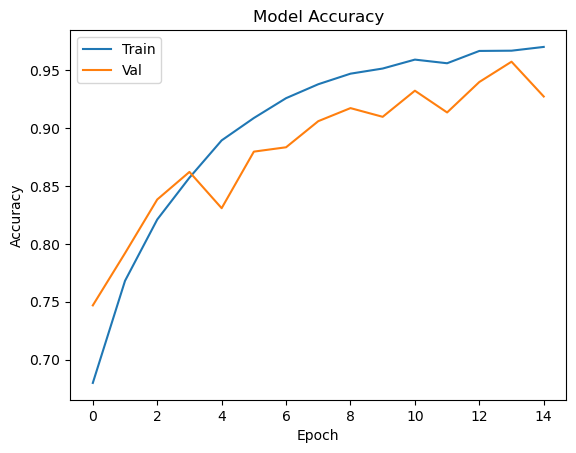

In [65]:
plot_acc(history_cnn)

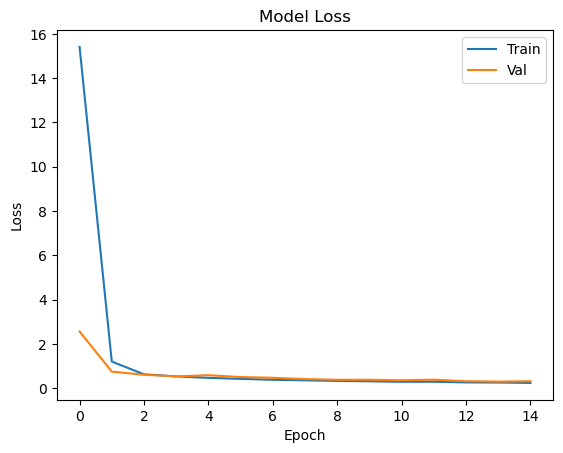

In [66]:
plot_loss(history_cnn)

In [71]:
model_cnn.evaluate(X_val, y_val, batch_size=32, verbose=1)

25/25 [==============================] - 1s 39ms/step - loss: 0.8904 - accuracy: 0.8885


[0.890381932258606, 0.8884711861610413]

In [72]:
model_cnn.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 [==============================] - 1s 44ms/step - loss: 0.9028 - accuracy: 0.8775


[0.9027836322784424, 0.8774703741073608]

In [31]:
prediction=model.predict(X_test, batch_size=32, verbose=1)

16/16 [==============================] - 1s 37ms/step


In [32]:
informe = classification_report(np.argmax(y_test,axis=1), np.argmax(prediction,axis=1))
print(informe)

AxisError: axis 1 is out of bounds for array of dimension 1